# EDA-3

## 1. 导入数据 

In [38]:
import pandas as pd
import numpy as np

In [39]:
df=pd.read_csv("../../Data Preparation/原始数据/cleaned_senti_reviews.csv")

In [40]:
df.shape

(130633, 58)

In [41]:
df.head(2)

,Unnamed: 0,reviewer_id,listing_id,date,reviewer_name,comments,name,description,neighborhood_overview,host_id,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,polarity_score,sentiment
0,0,8557223,49091,2013-10-21,Jared,Fran was absolutely gracious and welcoming. Ma...,COZICOMFORT LONG TERM STAY ROOM 2,This is Room No. 2.(available after Jan 15 201...,NaN,266763,...,10.0,10.0,10.0,8.0,8.0,f,2,0.02,0.9615,pos
1,1,1356099,50646,2014-04-18,James,A comfortable room in a smart condo developmen...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,...,10.0,10.0,10.0,9.0,9.0,f,1,0.30,0.9484,pos


##  2. 处理特征

###  2.1 高回复率 host_response_rate

#### 初探索 

In [42]:
df.host_response_rate.dtype

dtype('O')

In [43]:
df.host_response_rate.isnull().value_counts()

False    125371
True       5262
Name: host_response_rate, dtype: int64

In [44]:
df.host_response_rate.value_counts().head()

100%    81124
99%      7999
97%      5676
98%      5603
86%      3087
Name: host_response_rate, dtype: int64

首先，我们需要把所有的比例从当前的字符串转化为小数。里面的缺失值需要drop掉。

#### 舍弃这列的缺失值 

In [45]:
df.dropna(subset=["host_response_rate"],inplace=True)

In [46]:
df.shape

(125371, 58)

#### 改变字符串类型并转化为小数

In [47]:
df.host_response_rate = df.host_response_rate.apply(lambda x: int(x[:-1])/100)

In [48]:
df.host_response_rate.dtype

dtype('float64')

### 2.2 回复速度 host_response_time 

#### 初探索 

In [49]:
df.host_response_time.isnull().value_counts()

False    125371
Name: host_response_time, dtype: int64

现在发现没有空值，原因在于host_responce_time和host_response_rate是同时缺失。

我们之前已经删除了host_response_rate的缺失值，所以此时这个特征host_responce_time已经没有缺失值了

In [50]:
df.host_response_time.value_counts()

within an hour        96595
within a few hours    22579
within a day           5445
a few days or more      752
Name: host_response_time, dtype: int64

因此，我们需要把这四类改变成四个数字：回复时间越短，分数越高

   - "within an hour": 4      
   - "within a few hours": 3
   - "within a day": 2 
   - "a few days or more": 1

#### 将字符串替换为数字

In [51]:
df["host_response_time"].replace({"within an hour": 4,
                                  "within a few hours": 3,
                                  "within a day": 2, 
                                  "a few days or more": 1
                                  }, inplace=True)

In [52]:
df.host_response_time.value_counts()

4    96595
3    22579
2     5445
1      752
Name: host_response_time, dtype: int64

### 2.3 客户评论的分数 review_average_score

我们需要对客户的评论做sentimental analysis，从而得到一个分数来表示客户的喜爱度

#### 初探索 

In [53]:
df.comments.isnull().value_counts()

False    125370
True          1
Name: comments, dtype: int64

#### 删除comments的空值

In [54]:
df.dropna(subset=["comments"],inplace=True)

In [55]:
df.shape

(125370, 58)

#### 利用Afinn来计算分数 <font color=blue>**(略过此步骤)**</font>

In [30]:
from afinn import Afinn

In [31]:
afinn = Afinn()

In [ ]:
df["sentiment_score"]=df.comments.apply(lambda x: afinn.score(x))

In [ ]:
df.sentiment_score.describe()

In [ ]:
df.sentiment_score.value_counts()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
pyplot.plot(df.sentiment_score.value_counts(),"g*")
plt.show()

### 2.4 feature cross 特征交叉 

将 回复速度 host_response_time 和 高回复率 host_response_rate 进行特征交叉

交叉方式：host_response_time * host_response_rate

**分数结果越高越好**

In [87]:
df.host_response_time.value_counts()

4    96594
3    22579
2     5445
1      752
Name: host_response_time, dtype: int64

In [88]:
df["response_score"]=df.host_response_time+4*df.host_response_rate

In [89]:
df.response_score.value_counts()

8.00    69070
7.00    10657
7.96     7386
7.92     5180
7.88     4757
        ...  
4.08        1
2.36        1
1.96        1
2.88        1
1.36        1
Name: response_score, Length: 128, dtype: int64

## 3. 探索问题 

#### 把sentimental score合并，从房屋的视角出发

In [90]:
df2=df[["listing_id","response_score","polarity_score"]]
df2

,listing_id,response_score,polarity_score
0,49091,7.00,0.9615
19,56334,7.00,0.8316
20,56334,7.00,0.9825
21,56334,7.00,0.8851
22,56334,7.00,0.9077
...,...,...,...
130628,46568588,6.72,-0.8530
130629,46569171,6.72,0.9600
130630,46569258,6.72,0.5719
130631,46846222,6.72,0.7418


In [91]:
df3= pd.pivot_table(df2,
                    index=["listing_id"],
                    values=["response_score","polarity_score"]
                   )

In [92]:
df3

,polarity_score,response_score
listing_id,,
49091,0.961500,7.000000
56334,0.948600,7.000000
71609,0.756153,7.933333
71896,0.859250,8.000000
71903,0.636513,7.923077
...,...,...
46846222,0.802233,7.133333
47014450,0.726400,8.000000
47039804,0.585900,7.440000


#### 利用散点图探索response_score和polarity_score的关系

没有整合相同房屋：使用df2

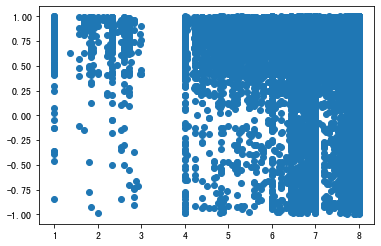

In [93]:
plt.scatter(df2.response_score,
            df2.polarity_score)
plt.show()

In [94]:
np.corrcoef(df2.response_score,
            df2.polarity_score)

array([[ 1.        , -0.02411435],
       [-0.02411435,  1.        ]])

整合了相同的房屋：使用df3

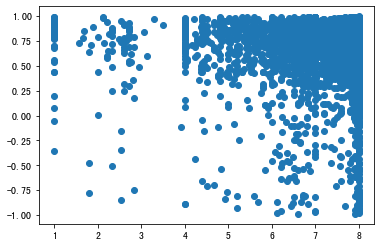

In [95]:
plt.scatter(df3.response_score,
            df3.polarity_score)

plt.show()

In [96]:
np.corrcoef(df3.polarity_score,df3.response_score)

array([[1.       , 0.0424672],
       [0.0424672, 1.       ]])